In [49]:
from crear_dataset import *
from funcions_net import *
import numpy as np
import matplotlib.pyplot as plt
import pyreadstat
import pandas as pd
from preprocessing import *
from sklearn.model_selection import train_test_split
from func_sel import *
from funcions_net import *


In [50]:

df_orig, meta = pyreadstat.read_sav("CEJFEAjut2015Updated.sav")

df_variables = pd.read_csv("variables.csv", sep=';')

dict = create_dict(meta)

df_psico = dataset_psicologia(df_orig, dict,df_variables)

df = drop_all_columns(df_psico, meta, df_variables, dict)

df_inicial = dataset_inicial(df_orig, dict)

# Aplanem els noms de columna per evitar problemes
df_inicial.columns = [str(col) for col in df_inicial.columns]

# Reiniciem índexs per alineació segura
df = df.reset_index(drop=True)
df_inicial = df_inicial.reset_index(drop=True)

# Eliminem del df_inicial les columnes que ja són a df
columnes_duplicades = df.columns.intersection(df_inicial.columns)
df_inicial = df_inicial.drop(columns=columnes_duplicades)

# Ara sí, concat segura
df = pd.concat([df, df_inicial], axis=1)


df['temps_fins_reincidencia1a'] = df_orig['temps_fins_reincidencia1a']

df['temps_fins_reincidencia1a'] = df['temps_fins_reincidencia1a'].apply(lambda x: 1095 if x > 1095 else x)

[73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 2

c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actual['Gitanos'] = np.where(df_anterior['Etnia'] ==1, 1, 0)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actual['Magrebins'] = np.where(df_anterior['Etnia'] ==2, 1, 0)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [51]:
print("Comprovant columnes després del concat:")
for col in df.columns:
    if isinstance(df[col], pd.DataFrame):
        print(f"⚠️ Columna {col} és un DataFrame!")
    elif df[col].ndim > 1:
        print(f"⚠️ Columna {col} té més d'una dimensió! shape = {df[col].shape}")

Comprovant columnes després del concat:


In [52]:
print("Mirem quants nans tenim a cada columna")

netejat,df = neteja_na_columns(df, llindar=0.6)


df = omple_nans(df)

print("Columnes netejades")
## fem label encoding de les columnes categòriques
df = label_encoding(df)


Mirem quants nans tenim a cada columna
Columnes netejades


In [53]:
num_columnes = df.shape[1]
print("Hem netejat les columnes i hem fet label encoding")
print("Tenim ", num_columnes, " columnes")

Hem netejat les columnes i hem fet label encoding
Tenim  405  columnes


In [54]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='temps_fins_reincidencia1a'), df['temps_fins_reincidencia1a'], test_size=0.2,random_state=20)


In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_train = pd.DataFrame(X_train, columns=df.drop(columns='temps_fins_reincidencia1a').columns)

In [56]:
from enns import *

# Creem un diccionari per emmagatzemar els resultats
resultats_enns = {}

# Fem les iteracions
for nb in [50, 100]:
    for it in [0.6, 0.7, 0.8]:
        for msr in [0.3, 0.5, 0.7]:
            selected_features = enns(X_train, y_train, n_bootstraps=nb, importance_threshold=it, min_selection_ratio=msr)
            
            # Creem una clau identificativa per aquests paràmetres
            clau = (nb, it, msr)
            
            # Guardem el resultat al diccionari
            resultats_enns[clau] = selected_features
            
            print(f"Bootstraps:{nb}, Threshold:{it}, MinRatio:{msr} => Seleccionades:{len(selected_features)}")


100%|██████████| 50/50 [03:11<00:00,  3.83s/it]


Bootstraps:50, Threshold:0.6, MinRatio:0.3 => Seleccionades:394


100%|██████████| 50/50 [02:49<00:00,  3.39s/it]


Bootstraps:50, Threshold:0.6, MinRatio:0.5 => Seleccionades:325


100%|██████████| 50/50 [05:40<00:00,  6.81s/it]


Bootstraps:50, Threshold:0.6, MinRatio:0.7 => Seleccionades:160


100%|██████████| 50/50 [07:05<00:00,  8.51s/it]


Bootstraps:50, Threshold:0.7, MinRatio:0.3 => Seleccionades:130


100%|██████████| 50/50 [06:52<00:00,  8.26s/it]


Bootstraps:50, Threshold:0.7, MinRatio:0.5 => Seleccionades:47


100%|██████████| 50/50 [05:23<00:00,  6.47s/it]


Bootstraps:50, Threshold:0.7, MinRatio:0.7 => Seleccionades:11


100%|██████████| 50/50 [04:12<00:00,  5.06s/it]


Bootstraps:50, Threshold:0.8, MinRatio:0.3 => Seleccionades:19


100%|██████████| 50/50 [04:12<00:00,  5.04s/it]


Bootstraps:50, Threshold:0.8, MinRatio:0.5 => Seleccionades:3


100%|██████████| 50/50 [04:25<00:00,  5.31s/it]


Bootstraps:50, Threshold:0.8, MinRatio:0.7 => Seleccionades:1


100%|██████████| 100/100 [08:53<00:00,  5.34s/it]


Bootstraps:100, Threshold:0.6, MinRatio:0.3 => Seleccionades:394


100%|██████████| 100/100 [09:46<00:00,  5.86s/it]


Bootstraps:100, Threshold:0.6, MinRatio:0.5 => Seleccionades:341


100%|██████████| 100/100 [14:37<00:00,  8.78s/it]


Bootstraps:100, Threshold:0.6, MinRatio:0.7 => Seleccionades:176


100%|██████████| 100/100 [14:37<00:00,  8.78s/it]


Bootstraps:100, Threshold:0.7, MinRatio:0.3 => Seleccionades:137


100%|██████████| 100/100 [12:36<00:00,  7.57s/it]


Bootstraps:100, Threshold:0.7, MinRatio:0.5 => Seleccionades:38


100%|██████████| 100/100 [08:26<00:00,  5.06s/it]


Bootstraps:100, Threshold:0.7, MinRatio:0.7 => Seleccionades:8


100%|██████████| 100/100 [07:31<00:00,  4.52s/it]


Bootstraps:100, Threshold:0.8, MinRatio:0.3 => Seleccionades:15


100%|██████████| 100/100 [13:08<00:00,  7.88s/it]


Bootstraps:100, Threshold:0.8, MinRatio:0.5 => Seleccionades:2


100%|██████████| 100/100 [14:22<00:00,  8.63s/it]

Bootstraps:100, Threshold:0.8, MinRatio:0.7 => Seleccionades:1


In [57]:
# Escriure els resultats ja emmagatzemats al diccionari en un fitxer
with open("resultats_enns.txt", "w") as f:
    for clau, selected_features in resultats_enns.items():
        nb, it, msr = clau
        f.write(f"Parameters:\n")
        f.write(f"  - Bootstraps: {nb}\n")
        f.write(f"  - Threshold: {it}\n")
        f.write(f"  - MinRatio: {msr}\n")
        f.write(f"Selected features ({len(selected_features)}):\n")
        for feat in selected_features:
            f.write(f"  · {feat}\n")
        f.write("-" * 60 + "\n")


In [58]:
columnes_seleccionades = resultats_enns[(50, 0.7, 0.3)]
print("Les columnes seleccionades són:", columnes_seleccionades)


Les columnes seleccionades són: [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  23  24  27
  28  33  34  35  36  44  45  47  50  51  59  60  62  65  75  76  77  82
  91  92  93  95  99 101 102 112 118 120 123 125 133 137 146 149 150 151
 152 161 175 179 184 187 192 195 201 208 210 211 214 215 218 224 227 228
 238 240 242 247 251 256 268 273 275 278 284 285 290 291 292 293 296 300
 309 310 313 319 322 326 336 338 341 355 359 360 361 362 363 364 365 369
 370 371 374 375 378 379 383 385 386 387 389 390 392 393 394 395 396 397
 400 401 402 403]


In [59]:
columnes = df.iloc[:, columnes_seleccionades].columns.tolist()
# O bé usant els noms directament:
print(columnes)

X_train_filtrat = X_train[columnes] 
X_test_filtrat = X_test[columnes]

['RAVEN01', 'RAVEN03', 'RAVEN05', 'RAVEN_PD', 'RAVEN_Pc', 'RAVEN_IQ', 'RAVENbarem', 'Raven_IQ2', 'RavenZ_2', 'Raven_IQ3', 'SAVRY01', 'SAVRY02', 'SAVRY03', 'SAVRY04', 'SAVRY05', 'SAVRY11', 'SAVRY12', 'SAVRY15', 'SAVRY16', 'SAVRY21', 'SAVRY22', 'SAVRY23', 'SAVRY24', 'SAVRY37', 'SAVRY39', 'SAVRY28', 'SAVRY29', 'DD01', 'DD09', 'DD10', 'DD12', 'VAST03', 'VAST13', 'VAST14', 'VAST15', 'VAST20', 'PCLe09', 'PCLe10', 'PCLe11', 'PCLe13', 'PCLe17', 'PCLe19', 'PCLe20', 'PCLo05', 'PCLo11', 'PCLo13', 'PCLo16', 'PCLo18', 'PCLx01', 'PCLx05', 'PCLx14', 'PCLx17', 'PCLx18', 'PCLx19', 'PCLx20', 'PCLj04', 'PCLj18', 'PCLjFAC_2', 'PCLYVM02', 'PCLYVM05', 'PCLYVM10', 'PCLYVM13', 'PCLYVM19', 'CAPEe01', 'CAPEe03', 'CAPEe04', 'CAPEo03', 'CAPEo04', 'CAPEo203', 'ICUT_UC', 'CCA_VA', 'CCA_AG', 'SD3Narc', 'SAVRYSoc', 'SAVRYTot', 'ICUJ_CA', 'YPI_DC', 'YPI_UN', 'TRFMTotProbT', 'TRFTDSMDepProb', 'TRFTDSMDepProbCat', 'TRFTDSMAnxProbCat', 'TRFTDSMADHDCat', 'TRFTDSMODD', 'TRFTDSMCDCat', 'TRFTDSMObsCom', 'TRFTDSMObsComT', 'TR

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Diccionari per guardar els resultats dels models
resultats_models = {}

# Paràmetres per al grid search
param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [30, 40, 50],
}

# Bucle per entrenar un model amb cada conjunt de columnes seleccionades
for clau, columnes_seleccionades in resultats_enns.items():
    print(f"\nParàmetres ENNS: {clau}")


    # Si hi ha columnes seleccionades, entrenem
    if len(columnes_seleccionades) > 0:
        # Filtratge de columnes
        columnes = df.iloc[:,columnes_seleccionades].columns.tolist()

        X_train_filtrat = X_train[columnes]
        X_test_filtrat = X_test[columnes]

        # Model i Grid Search
        rf = RandomForestRegressor()
        grid_search = GridSearchCV(
            rf,
            param_grid,
            cv=10,
            scoring='neg_mean_squared_error',
            return_train_score=True,
            n_jobs=-1
        )
        grid_search.fit(X_train_filtrat, y_train)

        # Guardem resultats
        resultats_models[clau] = {
            "best_params": grid_search.best_params_,
            "best_score": -grid_search.best_score_,
            "num_features": len(columnes)
        }

        print(f"   -> Best params: {grid_search.best_params_}")
        print(f"   -> Best MAE: {-grid_search.best_score_:.4f}")
    else:
        print("   -> Cap columna seleccionada. No s'entrena model.")



Paràmetres ENNS: (50, 0.6, 0.3)
   -> Best params: {'max_depth': 30, 'n_estimators': 250}
   -> Best MAE: 65662.5962

Paràmetres ENNS: (50, 0.6, 0.5)
   -> Best params: {'max_depth': 30, 'n_estimators': 250}
   -> Best MAE: 64337.0669

Paràmetres ENNS: (50, 0.6, 0.7)
   -> Best params: {'max_depth': 30, 'n_estimators': 250}
   -> Best MAE: 61714.9367

Paràmetres ENNS: (50, 0.7, 0.3)
   -> Best params: {'max_depth': 30, 'n_estimators': 100}
   -> Best MAE: 59028.1297

Paràmetres ENNS: (50, 0.7, 0.5)
   -> Best params: {'max_depth': 50, 'n_estimators': 250}
   -> Best MAE: 53124.5280

Paràmetres ENNS: (50, 0.7, 0.7)
   -> Best params: {'max_depth': 50, 'n_estimators': 100}
   -> Best MAE: 47410.9969

Paràmetres ENNS: (50, 0.8, 0.3)
   -> Best params: {'max_depth': 50, 'n_estimators': 100}
   -> Best MAE: 42204.6414

Paràmetres ENNS: (50, 0.8, 0.5)
   -> Best params: {'max_depth': 50, 'n_estimators': 250}
   -> Best MAE: 70068.4438

Paràmetres ENNS: (50, 0.8, 0.7)
   -> Best params: {'ma

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Diccionari per guardar els resultats dels models
resultats_models = {}

# Paràmetres per al grid search
param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [30, 40, 50],
}

# Bucle per entrenar un model amb cada conjunt de columnes seleccionades
for clau, columnes_seleccionades in resultats_enns.items():
    print(f"\nParàmetres ENNS: {clau}")


    # Si hi ha columnes seleccionades, entrenem
    if len(columnes_seleccionades) > 0:
        # Filtratge de columnes
        columnes = df.iloc[:,columnes_seleccionades].columns.tolist()

        X_train_filtrat = X_train[columnes]
        

        # Model i Grid Search
        rf = RandomForestRegressor()
        grid_search = GridSearchCV(
            rf,
            param_grid,
            cv=10,
            scoring='neg_mean_absolute_error',
            return_train_score=True,
            n_jobs=-1
        )
        grid_search.fit(X_train_filtrat, y_train)

        # Guardem resultats
        resultats_models[clau] = {
            "best_params": grid_search.best_params_,
            "best_score": -grid_search.best_score_,
            "best_model": grid_search.best_estimator_,
            "num_features": len(columnes)
        }

        print(f"   -> Best params: {grid_search.best_params_}")
        print(f"   -> Best MAE: {-grid_search.best_score_:.4f}")
    else:
        print("   -> Cap columna seleccionada. No s'entrena model.")



Paràmetres ENNS: (50, 0.6, 0.3)


   -> Best params: {'max_depth': 30, 'n_estimators': 100}
   -> Best MAE: 196.7180

Paràmetres ENNS: (50, 0.6, 0.5)
   -> Best params: {'max_depth': 40, 'n_estimators': 100}
   -> Best MAE: 195.3693

Paràmetres ENNS: (50, 0.6, 0.7)
   -> Best params: {'max_depth': 40, 'n_estimators': 100}
   -> Best MAE: 199.1373

Paràmetres ENNS: (50, 0.7, 0.3)
   -> Best params: {'max_depth': 30, 'n_estimators': 100}
   -> Best MAE: 186.4647

Paràmetres ENNS: (50, 0.7, 0.5)
   -> Best params: {'max_depth': 40, 'n_estimators': 100}
   -> Best MAE: 179.6572

Paràmetres ENNS: (50, 0.7, 0.7)
   -> Best params: {'max_depth': 50, 'n_estimators': 100}
   -> Best MAE: 171.3114

Paràmetres ENNS: (50, 0.8, 0.3)
   -> Best params: {'max_depth': 30, 'n_estimators': 500}
   -> Best MAE: 165.8431

Paràmetres ENNS: (50, 0.8, 0.5)
   -> Best params: {'max_depth': 50, 'n_estimators': 500}
   -> Best MAE: 190.0428

Paràmetres ENNS: (50, 0.8, 0.7)
   -> Best params: {'max_depth': 40, 'n_estimators': 100}
   -> Best MAE

Les columnes seleccionades són: ['RAVEN01', 'RAVEN03', 'RAVEN05', 'RAVEN_Pc', 'RAVEN_IQ', 'RAVENbarem', 'Raven_IQ2', 'RavenZ_2', 'Raven_IQ3', 'SAVRY01', 'SAVRY02', 'SAVRY03', 'SAVRY04', 'SAVRY05', 'SAVRY07', 'SAVRY11', 'SAVRY12', 'SAVRY13', 'SAVRY14', 'SAVRY16', 'SAVRY22', 'SAVRY23', 'SAVRY24', 'SAVRY37', 'SAVRY39', 'SAVRY29', 'DD01', 'DD10', 'DD11', 'VAST03', 'VAST05', 'VAST06', 'VAST13', 'VAST14', 'VAST15', 'VAST16', 'VAST20', 'PCLe07', 'PCLe10', 'PCLe11', 'PCLe16', 'PCLe18', 'PCLe19', 'PCLe20', 'PCLeFAC_4', 'PCLo05', 'PCLo11', 'PCLo16', 'PCLo18', 'PCLo19', 'PCLo20', 'PCLoFAC_3', 'PCLx01', 'PCLx05', 'PCLx06', 'PCLx13', 'PCLx16', 'PCLx18', 'PCLx19', 'PCLx20', 'PCLxFAC_1', 'PCLj04', 'PCLj09', 'PCLj18', 'PCLYVM02', 'PCLYVM05', 'PCLYVM18', 'PCLYVM19', 'CAPEe01', 'CAPEe03', 'CAPEe04', 'CAPEo03', 'CAPEo04', 'CAPEo201', 'CAPEo203', 'ICUT_UC', 'CCA_CN', 'CCA_VA', 'CCA_AG', 'SD3Narc', 'SAVRYSoc', 'ICUJ_CA', 'YPI_GR', 'YPI_LY', 'YPI_MA', 'YPI_UN', 'TRFMTotProb', 'TRFTDSMDepProbT', 'TRFTDSMDepP

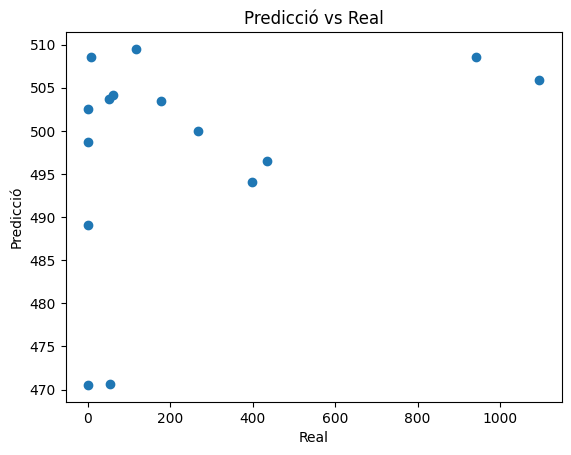

In [66]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

clau = (100, 0.7, 0.3)
columnes_seleccionades = resultats_enns[clau]
columnes = df.iloc[:,columnes_seleccionades].columns.tolist()
print("Les columnes seleccionades són:", columnes)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=df.drop(columns='temps_fins_reincidencia1a').columns)
X_test_filtrat = X_test[columnes]


y_test_pred = resultats_models[clau]["best_model"].predict(X_test_filtrat)


# Calculem la mètrica MSE i R²
test_mse = mean_squared_error(y_test, y_test_pred)

print("\n--- AVALUACIÓ FINAL EN TEST ---")
print(f"MSE (Test): {test_mse:.4f}")


## plot de les prediccions
plt.scatter(y_test, y_test_pred)
plt.xlabel('Real')
plt.ylabel('Predicció')
plt.title('Predicció vs Real')
plt.show()